In [2]:
import visual_behavior_glm.GLM_params as glm_params
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_visualization_tools as gvt
from visual_behavior_glm.glm import GLM
import matplotlib.pyplot as plt
import visual_behavior.data_access.loading as loading
import visual_behavior.database as db
import plotly.express as px

import pandas as pd
import numpy as np
import os
import copy 
import seaborn as sns

import visual_behavior.plotting as vbp

import plotly.express as px
from sklearn.cluster import KMeans
import umap
import hdbscan # First install the package on the terminal: pip install hdbscan

In [3]:
%matplotlib notebook
%widescreen

applied a custom magic command to make full use of screen width
will only work if command is defined locally
replace with the following to replicate functionality: 
	from IPython.core.display import display, HTML
	display(HTML("<style>.container { width:100% !important; }</style>")


# Gather/organize data

## load the results summary for a single GLM version from mongo

In [4]:
rs = gat.retrieve_results(search_dict = {'glm_version': '6_L2_optimize_by_cell'}, results_type='summary')
rs #.sample(10)

,_id,dropout,absolute_change_from_full,variance_explained,variance_explained_full,fraction_change_from_full,cell_specimen_id,adj_fraction_change_from_full,adj_variance_explained,adj_variance_explained_full,...,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,has_events,session_number,glm_version,entry_time_utc
0,5f4fd605cb47f470c067babd,Full,0.000000,0.004557,0.004557,0.000000,994090625,0.000000,0.004557,0.004557,...,Vip-IRES-Cre,NaN,NaN,0,0,Vip_VISl_306,0,2,6_L2_optimize_by_cell,2020-09-02 17:27:33.890208
1,5f4fd605cb47f470c067babe,all-images,-0.004557,0.000000,0.004557,0.000000,994090625,0.000000,0.000000,0.004764,...,Vip-IRES-Cre,NaN,NaN,0,0,Vip_VISl_306,0,2,6_L2_optimize_by_cell,2020-09-02 17:27:33.893275
2,5f4fd605cb47f470c067babf,change,0.000035,0.004592,0.004557,0.000000,994090625,0.000000,0.000000,0.000000,...,Vip-IRES-Cre,NaN,NaN,0,0,Vip_VISl_306,0,2,6_L2_optimize_by_cell,2020-09-02 17:27:33.896009
3,5f4fd605cb47f470c067bac0,correct_rejects,0.000273,0.004830,0.004557,0.000000,994090625,0.000000,0.000000,0.000000,...,Vip-IRES-Cre,NaN,NaN,0,0,Vip_VISl_306,0,2,6_L2_optimize_by_cell,2020-09-02 17:27:33.898306
4,5f4fd605cb47f470c067bac1,face_motion_energy,0.019050,0.023607,0.004557,0.000000,994090625,0.000000,0.024064,0.004794,...,Vip-IRES-Cre,NaN,NaN,0,0,Vip_VISl_306,0,2,6_L2_optimize_by_cell,2020-09-02 17:27:33.900699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2976453,5f528cd43ed30081f0e50395,single-running,-0.006422,0.002380,0.008802,0.000000,962559644,0.000000,0.002373,0.008918,...,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_375,0,1,6_L2_optimize_by_cell,2020-09-04 18:52:04.340130
2976454,5f528cd43ed30081f0e50396,single-time,-0.008525,0.000276,0.008802,0.000000,962559644,0.000000,0.000276,0.008802,...,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_375,0,1,6_L2_optimize_by_cell,2020-09-04 18:52:04.342484
2976455,5f528cd43ed30081f0e50397,single-visual,0.004420,0.013222,0.008802,-1.000000,962559644,-1.000000,0.013225,0.008960,...,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_375,0,1,6_L2_optimize_by_cell,2020-09-04 18:52:04.345094
2976456,5f528cd43ed30081f0e50398,time,-0.000053,0.008749,0.008802,-0.006045,962559644,-0.006045,0.008749,0.008802,...,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_375,0,1,6_L2_optimize_by_cell,2020-09-04 18:52:04.347741


In [7]:
rs.columns

Index(['_id', 'dropout', 'absolute_change_from_full', 'variance_explained',
       'variance_explained_full', 'fraction_change_from_full',
       'cell_specimen_id', 'adj_fraction_change_from_full',
       'adj_variance_explained', 'adj_variance_explained_full',
       'ophys_experiment_id', 'ophys_session_id', 'behavior_session_id',
       'container_id', 'project_code', 'container_workflow_state',
       'experiment_workflow_state', 'session_name', 'session_type',
       'equipment_name', 'date_of_acquisition', 'isi_experiment_id',
       'specimen_id', 'sex', 'age_in_days', 'full_genotype', 'reporter_line',
       'driver_line', 'imaging_depth', 'targeted_structure', 'published_at',
       'super_container_id', 'cre_line', 'session_tags', 'failure_tags',
       'exposure_number', 'model_outputs_available', 'location', 'has_events',
       'session_number', 'glm_version', 'entry_time_utc'],
      dtype='object')

2976458

# get a list of columns to use for clustering. Defining this list now makes it easier to avoid accidentally clustering on some identifying feature (e.g., cre_line, session_type, etc.)
I'm removing the 'visual' dropout, since it's actually a combination of the omission and all-images dropouts.

In [6]:
cols_for_clustering = list(rs['dropout'].unique())
cols_for_clustering.remove('visual')
cols_for_clustering

['Full',
 'all-images',
 'change',
 'correct_rejects',
 'face_motion_energy',
 'image0',
 'image1',
 'image2',
 'image3',
 'image4',
 'image5',
 'image6',
 'image7',
 'image_expectation',
 'intercept',
 'misses',
 'omissions',
 'post_lick_bouts',
 'post_licks',
 'pre_lick_bouts',
 'pre_licks',
 'pupil',
 'running',
 'single-all-images',
 'single-change',
 'single-correct_rejects',
 'single-face_motion_energy',
 'single-image0',
 'single-image1',
 'single-image2',
 'single-image3',
 'single-image4',
 'single-image5',
 'single-image6',
 'single-image7',
 'single-image_expectation',
 'single-misses',
 'single-omissions',
 'single-post_lick_bouts',
 'single-post_licks',
 'single-pre_lick_bouts',
 'single-pre_licks',
 'single-pupil',
 'single-running',
 'single-time',
 'single-visual',
 'time',
 'beh_model',
 'false_alarms',
 'hits',
 'model_bias',
 'model_omissions1',
 'model_task0',
 'model_timing1D',
 'rewards',
 'single-beh_model',
 'single-false_alarms',
 'single-hits',
 'single-model_

## build a pivoted version of the results summary, using the `fraction_change_from_full` column as the values.

In [8]:
rsp = gat.build_pivoted_results_summary(results_summary=rs, cutoff=0.1, value_to_use='adj_fraction_change_from_full')


dropping ['_id', 'dropout', 'variance_explained', 'fraction_change_from_full', 'absolute_change_from_full', 'adj_fraction_change_from_full', 'adj_variance_explained', 'adj_variance_explained_full', 'entry_time_utc']


In [9]:
len(rsp)

8095

In [11]:
rsp['cre_line'].value_counts()

Slc17a7-IRES2-Cre    5255
Sst-IRES-Cre         1641
Vip-IRES-Cre         1199
Name: cre_line, dtype: int64

In [8]:
# check what fraction of cells are kept after applying the cutoff above.
np.unique(rs['cell_specimen_id']).shape, np.unique(rsp['cell_specimen_id']).shape, np.unique(rsp['cell_specimen_id']).shape[0]/np.unique(rs['cell_specimen_id']).shape[0]

((24656,), (5463,), 0.22156878650227124)

In [9]:
rs.columns, rsp.columns, rs.shape, rsp.shape

(Index(['_id', 'index', 'dropout', 'variance_explained',
        'fraction_change_from_full', 'absolute_change_from_full',
        'cell_specimen_id', 'ophys_experiment_id', 'ophys_session_id',
        'behavior_session_id', 'container_id', 'project_code',
        'container_workflow_state', 'experiment_workflow_state', 'session_name',
        'session_type', 'equipment_name', 'date_of_acquisition',
        'isi_experiment_id', 'specimen_id', 'sex', 'age_in_days',
        'full_genotype', 'reporter_line', 'driver_line', 'imaging_depth',
        'targeted_structure', 'published_at', 'super_container_id', 'cre_line',
        'session_tags', 'failure_tags', 'exposure_number',
        'model_outputs_available', 'location', 'glm_version', 'entry_time_utc',
        'identifier'],
       dtype='object'),
 Index(['identifier', 'Full', 'all-images', 'beh_model', 'change',
        'correct_rejects', 'false_alarms', 'hits', 'image0', 'image1', 'image2',
        'image3', 'image4', 'image5', 'imag

## add a `session_id` column with a numeric value for the session_type (to lump together sessions by order, regardless of image set)

In [10]:
def map_session_types(session_type):
    session_id = int(session_type[6:7])
    if session_id==4:
        session_id=1 # novel
    else:
        session_id=0 # not novel
    return session_id

rsp['session_id'] = rsp['session_type'].map(lambda st:map_session_types(st))


In [11]:
sum(rsp['session_id']==0), sum(rsp['session_id']==1)

(5119, 2220)

## Turn some categorical columns into numerical columns

In [12]:
def make_categorical(df, column):
    df['{}_categorical'.format(column)] = pd.Categorical(df[column], ordered=True).codes

for column in ['cre_line','equipment_name','targeted_structure','session_id']:
    make_categorical(rsp, column)


In [13]:
rsp00 = copy.deepcopy(rsp)

## Merge the behavioral glm df with rsp

In [14]:
# load the behavioral model for each session
# for now we care about 'task_dropout_index'
# task_weight_index is the average value of the task weight for that session. 
# task_dropout_index is the value of the (task dropout - timing dropout). 
# task_only_dropout_index is just task dropout

data = loading.get_behavior_model_summary_table()
# data['task_dropout_index']
data.shape

/home/farzaneh/anaconda2/envs/visbeh/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(333, 64)

In [15]:
# compare number of sessions for the behavioral and neural glm models
np.unique(data['ophys_session_id'].values).shape, np.unique(rsp00['ophys_session_id'].values).shape

((333,), (241,))

In [16]:
rsp00.shape

(7339, 68)

In [17]:
# merge rsp and data on session_id
# rsp = rsp.merge(data, on=['ophys_session_id'])
rsp = rsp00.merge(data, on=['ophys_session_id', 'cre_line']) #, how='outer')
rsp.shape

(7300, 130)

In [18]:
np.unique(rsp['ophys_session_id'].values).shape

(236,)

In [19]:
list(rsp.columns) #, rsp.shape

['identifier',
 'Full',
 'all-images',
 'beh_model',
 'change',
 'correct_rejects',
 'false_alarms',
 'hits',
 'image0',
 'image1',
 'image2',
 'image3',
 'image4',
 'image5',
 'image6',
 'image7',
 'image_expectation',
 'intercept',
 'misses',
 'model_bias',
 'model_omissions1',
 'model_task0',
 'model_timing1D',
 'omissions',
 'post_lick_bouts',
 'post_licks',
 'pre_lick_bouts',
 'pre_licks',
 'pupil',
 'rewards',
 'running',
 'time',
 'visual',
 'cell_specimen_id',
 'ophys_experiment_id_x',
 'ophys_session_id',
 'behavior_session_id_x',
 'container_id_x',
 'project_code_x',
 'container_workflow_state',
 'experiment_workflow_state',
 'session_name',
 'session_type_x',
 'equipment_name_x',
 'date_of_acquisition_x',
 'isi_experiment_id',
 'specimen_id_x',
 'sex_x',
 'age_in_days_x',
 'full_genotype_x',
 'reporter_line_x',
 'driver_line_x',
 'imaging_depth_x',
 'targeted_structure',
 'published_at',
 'super_container_id',
 'cre_line',
 'session_tags',
 'failure_tags',
 'exposure_number'

In [20]:
# rsp.iloc[1298]['ophys_experiment_id_x'], rsp.iloc[1298]['ophys_experiment_id_y']

(825120601, '[825120601]')

In [21]:
# rsp[rsp['ophys_experiment_id_x'].values==795948257][['cell_specimen_id', 'beh_model']]

,cell_specimen_id,beh_model
392,962561349,0.000763
393,962562513,0.004477
394,962564424,-0.020650
395,962564657,-0.004491
396,962565055,0.009673
397,962565415,-0.009405
398,962566819,0.004154
399,962567653,-0.002937
400,962568849,0.002381
401,962569492,0.000472


## Redefine cols_for_clustering
### add some features from behavioral glm to rsp 

In [ ]:
# make sure to not add features that get repeated across cells (eg task_dropout_index will be repeated for all cells of the same session)
# cols_for_clustering.append('task_dropout_index')
# np.shape(cols_for_clustering), cols_for_clustering

# Dimensionality reduction and clustering
So many more things to try here. This is just a start.

## UMAP

In [24]:
neigh_vals = np.concatenate(([5, 10, 15, 50], np.arange(200, int(rsp.shape[0]/10), 500)))
print(neigh_vals)

[  5  10  15  50 200 700]


In [26]:
rsp.shape, rsp[cols_for_clustering].shape, cols_for_clustering

((7300, 130),
 (7300, 24),
 ['Full',
  'intercept',
  'time',
  'pre_licks',
  'post_licks',
  'rewards',
  'change',
  'hits',
  'misses',
  'false_alarms',
  'correct_rejects',
  'omissions',
  'image_expectation',
  'running',
  'pupil',
  'image0',
  'image1',
  'image2',
  'image3',
  'image4',
  'image5',
  'image6',
  'image7',
  'all-images'])

In [101]:
n_components = 15 # dimensions of original data: np.shape(cols_for_clustering)[0]

mindist = 0.1 # default: .1 
neigh = neigh_vals[0]

reducer = umap.UMAP(n_components=n_components, min_dist = mindist, n_neighbors = neigh)
embedding = reducer.fit_transform(rsp[cols_for_clustering])
print(embedding.shape)

# reducer_2d = umap.UMAP(n_components=2)
# reducer_3d = umap.UMAP(n_components=3)

# embedding_2d = reducer_2d.fit_transform(rsp[cols_for_clustering])
# embedding_3d = reducer_3d.fit_transform(rsp[cols_for_clustering])

# keep these dimensions for plotting
rsp['umap_3d_embedding_0'] = embedding[:, 0]
rsp['umap_3d_embedding_1'] = embedding[:, 1]
rsp['umap_3d_embedding_2'] = embedding[:, 2]

# rsp['umap_2d_embedding_0'] = embedding_2d[:, 0]
# rsp['umap_2d_embedding_1'] = embedding_2d[:, 1]

(7300, 15)


In [102]:
embedding.shape, neigh, mindist

((7300, 15), 5, 0.1)

## k-means clustering on 3d umap


In [29]:
kmeans = KMeans(n_clusters=20)
umap_cols = ['umap_3d_embedding_0','umap_3d_embedding_1','umap_3d_embedding_2']
rsp['clusterer_labels'] = kmeans.fit_predict(rsp[umap_cols])
rsp['clusterer_labels'].value_counts()

kmeans = KMeans(n_clusters=20)
umap_cols = ['umap_3d_embedding_0','umap_3d_embedding_1','umap_3d_embedding_2']
rsp['clusterer_labels'] = kmeans.fit_predict(rsp[umap_cols])
rsp['clusterer_labels'].value_counts()

15    597
11    532
8     532
1     496
14    472
13    462
5     455
19    388
0     379
2     372
7     370
6     350
10    350
18    336
16    307
17    276
9     194
3     163
12    163
4     106
Name: clusterer_labels, dtype: int64

## hdbscan clustrering

In [103]:
# Try a range of parameters

min_cluster_size_all = [5, 20, 50, 100, 200] #100 #50 # (default=5)
min_samples_all = [10] #10 #min_cluster_size #18 # default: same as min_cluster_size

clusterer_all = []
clusterer_labels_all = []
clusterer_params = []
val_per_clust_all = []
cluster_ids_all = []

for min_cluster_size in min_cluster_size_all:
    for min_samples in np.unique(np.concatenate((min_samples_all, [min_cluster_size]))):
        
        print('______________________')
        min_cluster_size = int(min_cluster_size)
        min_samples = int(min_samples)
        print([min_cluster_size, min_samples])
        
        ### set cluster_selection_epsilon to .5
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=.5) #(min_cluster_size=9, gen_min_span_tree=True)

        ### don't set cluster_selection_epsilon
#         clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        
        clusterer.fit(embedding) # rsp[umap_cols]
        
        clusterer_labels_ = clusterer.labels_
        val_per_clust = [np.sum(clusterer.labels_ == np.unique(clusterer.labels_)[i]) for i in range(len(np.unique(clusterer.labels_)))] # number of points per cluster
        cluster_ids = np.unique(clusterer.labels_)
        
        print(cluster_ids[[0,-1]])
        print(val_per_clust)
        
        clusterer_labels_all.append(clusterer_labels_) # cluster_labels = clusterer.fit_predict(embedding)
        clusterer_all.append(clusterer)
        clusterer_params.append([min_cluster_size, min_samples])
        val_per_clust_all.append(val_per_clust)
        cluster_ids_all.append(cluster_ids)

______________________
[5, 5]
[-1 17]
[32, 33, 34, 48, 39, 55, 16, 49, 24, 110, 30, 23, 37, 10, 129, 16, 41, 27, 6547]
______________________
[5, 10]
[-1 17]
[238, 33, 34, 48, 39, 55, 16, 49, 24, 110, 140, 30, 105, 23, 23, 39, 29, 16, 6249]
______________________
[20, 10]
[-1 15]
[242, 33, 34, 48, 39, 55, 49, 24, 110, 140, 30, 105, 23, 23, 39, 29, 6277]
______________________
[20, 20]
[0 2]
[7233, 34, 33]
______________________
[50, 10]
[-1  6]
[417, 67, 55, 110, 140, 105, 65, 6341]
______________________
[50, 50]
[0 1]
[67, 7233]
______________________
[100, 10]
[-1  3]
[389, 110, 140, 105, 6556]
______________________
[100, 100]
[-1  1]
[2077, 487, 4736]
______________________
[200, 10]
[-1  1]
[1268, 2966, 3066]
______________________
[200, 200]
[-1  2]
[3409, 457, 591, 2843]


In [80]:
rsp = rspall

In [79]:
embedding.shape

(7300, 10)

In [104]:
min_cluster_size = 100 #50 # (default=5)
min_samples = 10 #min_cluster_size #18 # default: same as min_cluster_size

clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=.5)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples) #(min_cluster_size=9, gen_min_span_tree=True)

clusterer.fit(embedding) # rsp[umap_cols]
# clusterer.labels_ # cluster_labels = clusterer.fit_predict(embedding)
# clusterer.probabilities_
rsp['clusterer_labels'] = clusterer.labels_
val_per_clust = rsp['clusterer_labels'].value_counts().values # number of points per cluster

In [105]:
# fract_per_clust = [np.mean(clusterer.labels_ == np.unique(clusterer.labels_)[i]) for i in range(len(np.unique(clusterer.labels_)))]
print(len(np.unique(clusterer.labels_)))
# noise points
print(sum(clusterer.labels_ == -1), np.mean(clusterer.labels_ == -1))

rsp['clusterer_labels'].value_counts()


5
389 0.05328767123287671


 3    6556
-1     389
 1     140
 0     110
 2     105
Name: clusterer_labels, dtype: int64

In [84]:
# evaluate clustering results

# print(val_per_clust.shape)
print(np.sort(val_per_clust))

# # number of clusters with <th_neur neurons in them.
# th_n = 20 # we dont want to have less than 20 neurons in a cluster, maybe.
# print(sum(val_per_clust < th_n), np.mean(val_per_clust < th_n))

# # noise points
# print(sum(clusterer.labels_ == -1), np.mean(clusterer.labels_ == -1))

[ 110  136  137  143  171  228  631 5744]


<IPython.core.display.Javascript object>


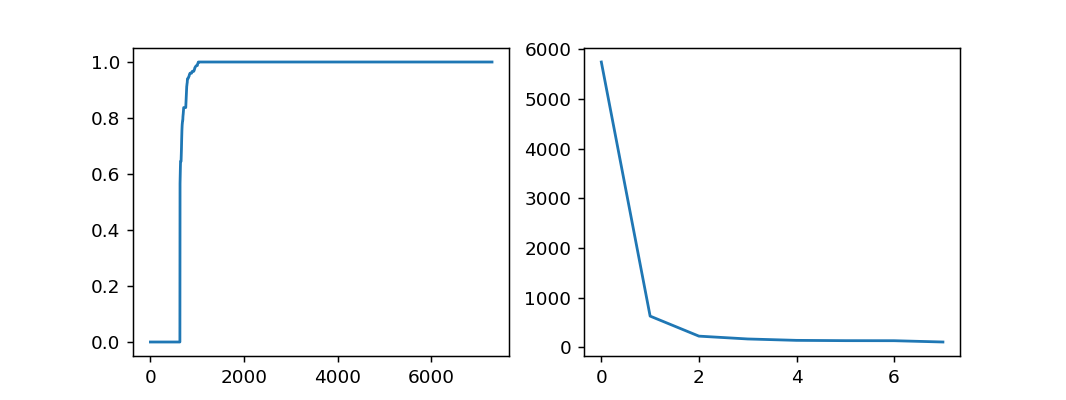

[0.         0.51142973 0.55194786 0.56577941 0.57260365 0.57651222
 0.58087684 0.58375854 0.58566477 0.59497402 0.6184854  0.62693982
 0.64489137 0.64958856 0.65106698 0.65311302 0.65635411 0.67254748
 0.68234612 0.68322707 0.6884215  0.70577356 0.71201213 0.71825915
 0.71855104 0.72296745 0.72533904 0.72861968 0.74321291 0.75091805
 0.75470702 0.76309033 0.76485605 0.76628839 0.76818593 0.77318811
 0.7793063  0.78052222 0.78082268 0.78348081 0.78402851 0.78589263
 0.78795383 0.79017822 0.79025178 0.79097897 0.7914409  0.79218836
 0.7924802  0.8023468  0.80257896 0.80431267 0.80789551 0.80940799
 0.81029581 0.8120373  0.8128009  0.81741663 0.81935948 0.81997401
 0.82142354 0.82435479 0.83083002 0.83345371 0.83353925 0.83573638
 0.83728348 0.84119612 0.84475477 0.8466561  0.84881781 0.85270426
 0.853195   0.85781581 0.86494214 0.87513938 0.875855   0.87860772
 0.88427837 0.89117418 0.89169762 0.89796267 0.90449758 0.90606729
 0.90744442 0.9079622  0.90873972 0.91306226 0.91363738 0.9150

In [85]:
# plot clusterer probabilities and number of cells in each label.

plt.figure(figsize=(8,3))

plt.subplot(121), plt.plot(np.sort(clusterer.probabilities_))
plt.subplot(122), plt.plot(val_per_clust)
print(np.unique(clusterer.probabilities_))

## visualize in 2d using matplotlib

<IPython.core.display.Javascript object>


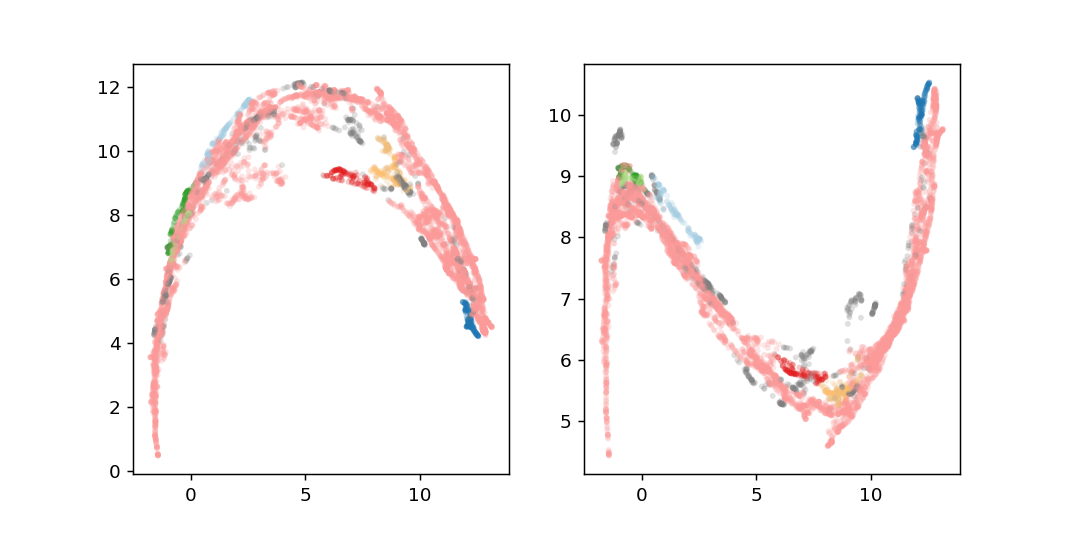

In [86]:
color_palette = sns.color_palette('Paired', len(rsp['clusterer_labels'].unique()))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(rsp['umap_3d_embedding_0'], rsp['umap_3d_embedding_1'], s=10, linewidth=0, c=cluster_member_colors, alpha=0.25)

plt.subplot(122)
plt.scatter(rsp['umap_3d_embedding_0'], rsp['umap_3d_embedding_2'], s=10, linewidth=0, c=cluster_member_colors, alpha=0.25)



<IPython.core.display.Javascript object>


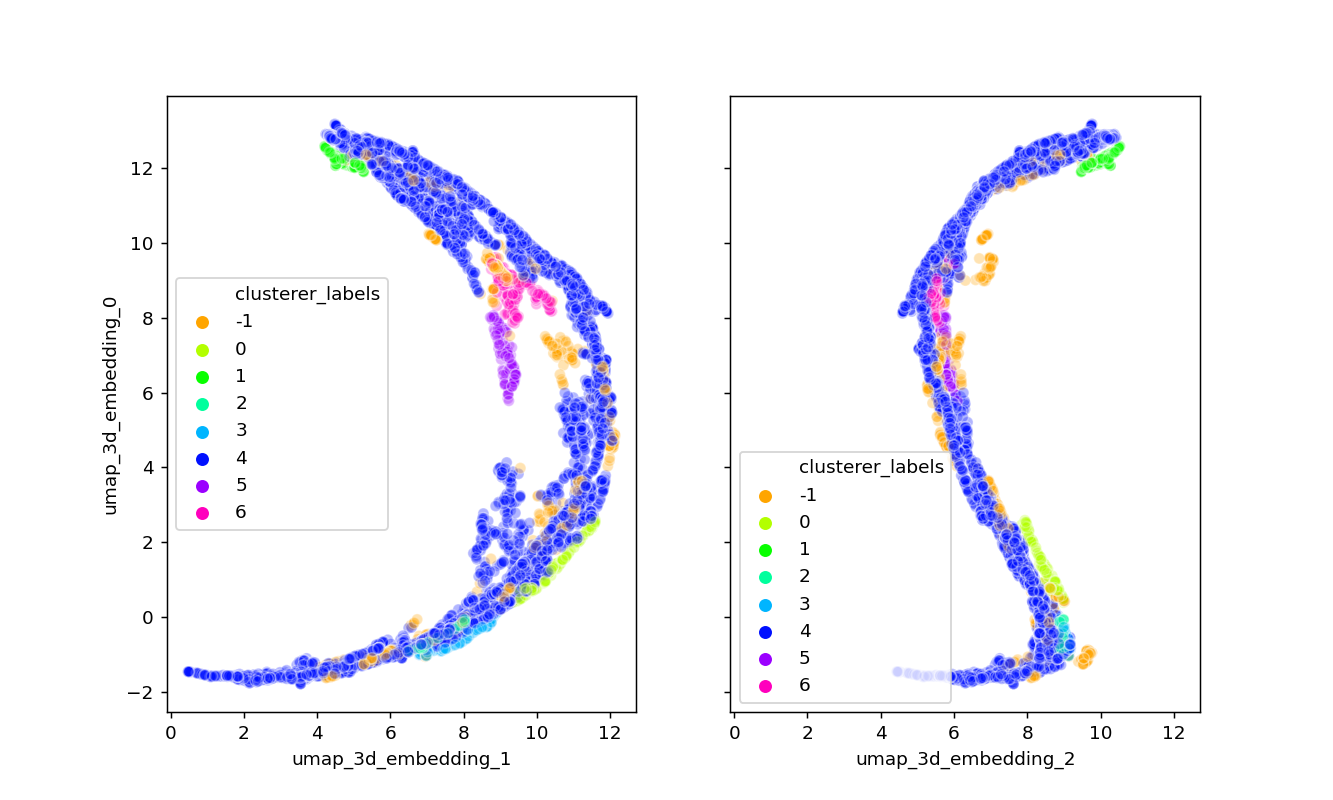

In [87]:
fig,ax=plt.subplots(1,2,figsize=(10,6),sharey=True,sharex=True)
sns.scatterplot(
    x='umap_3d_embedding_1', 
    y='umap_3d_embedding_0',
    hue='clusterer_labels',
    palette=sns.color_palette("hsv", len(rsp['clusterer_labels'].unique())),
    data=rsp,
    legend='full',
    alpha=0.3,
    ax=ax[0],
)
sns.scatterplot(
    x='umap_3d_embedding_2', 
    y='umap_3d_embedding_0',
    hue='clusterer_labels',
    palette=sns.color_palette("hsv", len(rsp['clusterer_labels'].unique())),
    data=rsp,
    legend='full',
    alpha=0.3,
    ax=ax[1],
)

## visualize in 3d using plotly

In [88]:
fig = px.scatter_3d(
    rsp, 
    x='umap_3d_embedding_0', 
    y='umap_3d_embedding_1', 
    z='umap_3d_embedding_2',
    color='clusterer_labels',
    color_continuous_scale='hsv',
)

fig.update_traces(marker=dict(size=3))

# optional view positioning parameters (I don't really understand these, just toying with them to get a view I like!)
camera = dict(
    up=dict(x=3, y=1.75, z=0.25),
    eye=dict(x=1.5, y=1.5, z=-0.2)
)

fig.update_layout(
    scene_camera=camera,
    margin=dict(l=30, r=30, t=10, b=10),
    width=1200,
    height=1000,
)
# fig.write_html("/home/dougo/code/dougollerenshaw.github.io/figures_to_share/2020.08.21_k_means_on_umap.html")
fig.show()

# A little bit of prep for plotting

## first define the dominant dropout in each cluster

In [106]:
# identify dominant dropouts for each cluster
gat.identify_dominant_dropouts(rsp, cluster_column_name='clusterer_labels', cols_to_search=cols_for_clustering)

In [107]:
np.unique(rsp['dominant_dropout'])

array(['all-images'], dtype=object)

In [108]:
for column in ['dominant_dropout']:
    make_categorical(rsp, column)

## only get those rsp rows that have non-noise cluster values

In [109]:
rsp['clusterer_labels'].value_counts(), sum(rsp['clusterer_labels'].value_counts())

( 3    6556
 -1     389
  1     140
  0     110
  2     105
 Name: clusterer_labels, dtype: int64,
 7300)

In [96]:
rspall = copy.deepcopy(rsp)
rspall.shape

(7300, 137)

In [97]:
# use all rsp rows in clustering
rsp = rspall
rsp.shape

(7300, 137)

In [72]:
# only get those rsp rows that have non-noise cluster values
rsp = rspall[rspall['clusterer_labels'] != -1]
rsp.shape

(5638, 137)

In [98]:
np.unique(rsp['dominant_dropout'])

array(['all-images', 'running'], dtype=object)

## define heatmap parameters
lots here, but there are lots of options!

In [110]:
cols_to_plot = [
    'clusterer_labels',      
    'all-images', 
    'omissions', 
    'pupil', 
    'running',
    'cre_line_categorical', 
    'dominant_dropout_categorical',
    'session_id_categorical', 
#    'equipment_name_categorical',
#    'targeted_structure_categorical',
#    'imaging_depth',
    'task_dropout_index',  
]

# make sure there's a heatmap definition for every column, otherwise the column will plot without a heatmap!
heatmap_defs = [
    {
        'columns':cols_to_plot[1:5],
        'cbar_label':'fraction change\nin var explained',
        'cbar_ticks':[-1,0,1],
        'vmin':-1,
        'vmax':1,
        'cmap':'bwr',
    },
    {
        'columns':['cre_line_categorical'],
        'cbar_label':'cre_line',
        'cbar_ticks':[0,1,2],
        'cbar_ticklabels':np.sort(np.unique(rsp['cre_line'])),
        'vmin':-0.5,
        'vmax':2.5,
        'cmap':sns.color_palette("hls", 3),
    },    
    {
        'columns':['dominant_dropout_categorical'],
        'cbar_label':'dominant_dropout_categorical',
        'cbar_ticks':np.arange(len(rsp['dominant_dropout_categorical'].unique())),
        'cbar_ticklabels':np.sort(np.unique(rsp['dominant_dropout'])),
        'vmin':-0.5,
        'vmax':len(rsp['dominant_dropout_categorical'].unique())-0.5,
        'cmap':sns.color_palette("hls", len(rsp['dominant_dropout_categorical'].unique())),

    },
    {
        'columns':['session_id_categorical'],
        'cbar_label':'session ID',
        'cbar_ticks':[0,1], #[0,1,2,3],
        'cbar_ticklabels':['familiar', 'novel'], #[1,3,4,6],
        'vmin':-0.5,
        'vmax':1.5, #3.5,
        'cmap':sns.color_palette("Dark2", 2), # 4
    },
    {
        'columns':['clusterer_labels'],
        'cbar_label':'k-means label',
        'cbar_ticks':np.arange(min(rsp['clusterer_labels'].unique()),len(rsp['clusterer_labels'].unique()),2),
        'vmin':min(rsp['clusterer_labels'].unique()),
        'vmax':len(rsp['clusterer_labels'].unique())-1,
        'cmap':sns.color_palette("hsv", len(rsp['clusterer_labels'].unique())),
    },
#     {
#         'columns':['equipment_name_categorical'],
#         'cbar_label':'equipment name',
#         'cbar_ticks':np.arange(len(rsp['equipment_name_categorical'].unique())),
#         'cbar_ticklabels':np.sort(np.unique(rsp['equipment_name'])),
#         'vmin':-0.5,
#         'vmax':len(rsp['equipment_name_categorical'].unique())-0.5,
#         'cmap':sns.color_palette("hls", len(rsp['equipment_name_categorical'].unique())),
#     },
#     {
#         'columns':['targeted_structure_categorical'],
#         'cbar_label':'targeted structure',
#         'cbar_ticks':np.arange(len(rsp['targeted_structure_categorical'].unique())),
#         'cbar_ticklabels':np.sort(np.unique(rsp['targeted_structure'])),
#         'vmin':-0.5,
#         'vmax':len(rsp['targeted_structure'].unique())-0.5,
#         'cmap':sns.color_palette("hls", len(rsp['targeted_structure'].unique())),
#     },
#     {
#         'columns':['imaging_depth'],
#         'cbar_label':'imaging_depth',
#         'cbar_ticks':[0,100,200,300,400],
#         'vmin':0,
#         'vmax':400,
#         'cmap':'magma',
#     },
    {
        'columns':['task_dropout_index'],
        'cbar_label':'task_dropout_index',
        'cmap':'inferno',
    },    
]

# Make heatmaps, sort by whatever we want
Note that it only makes sense to nest sorting values for categorical data. Any sorting value that follows a continuous variable will not have any effect.

## First sort by dominant dropout, the median value of the dominant dropout (for cases with multiple clusters sharing the same dominant dropout), then cre_line, session_id, imaging_depth

<IPython.core.display.Javascript object>


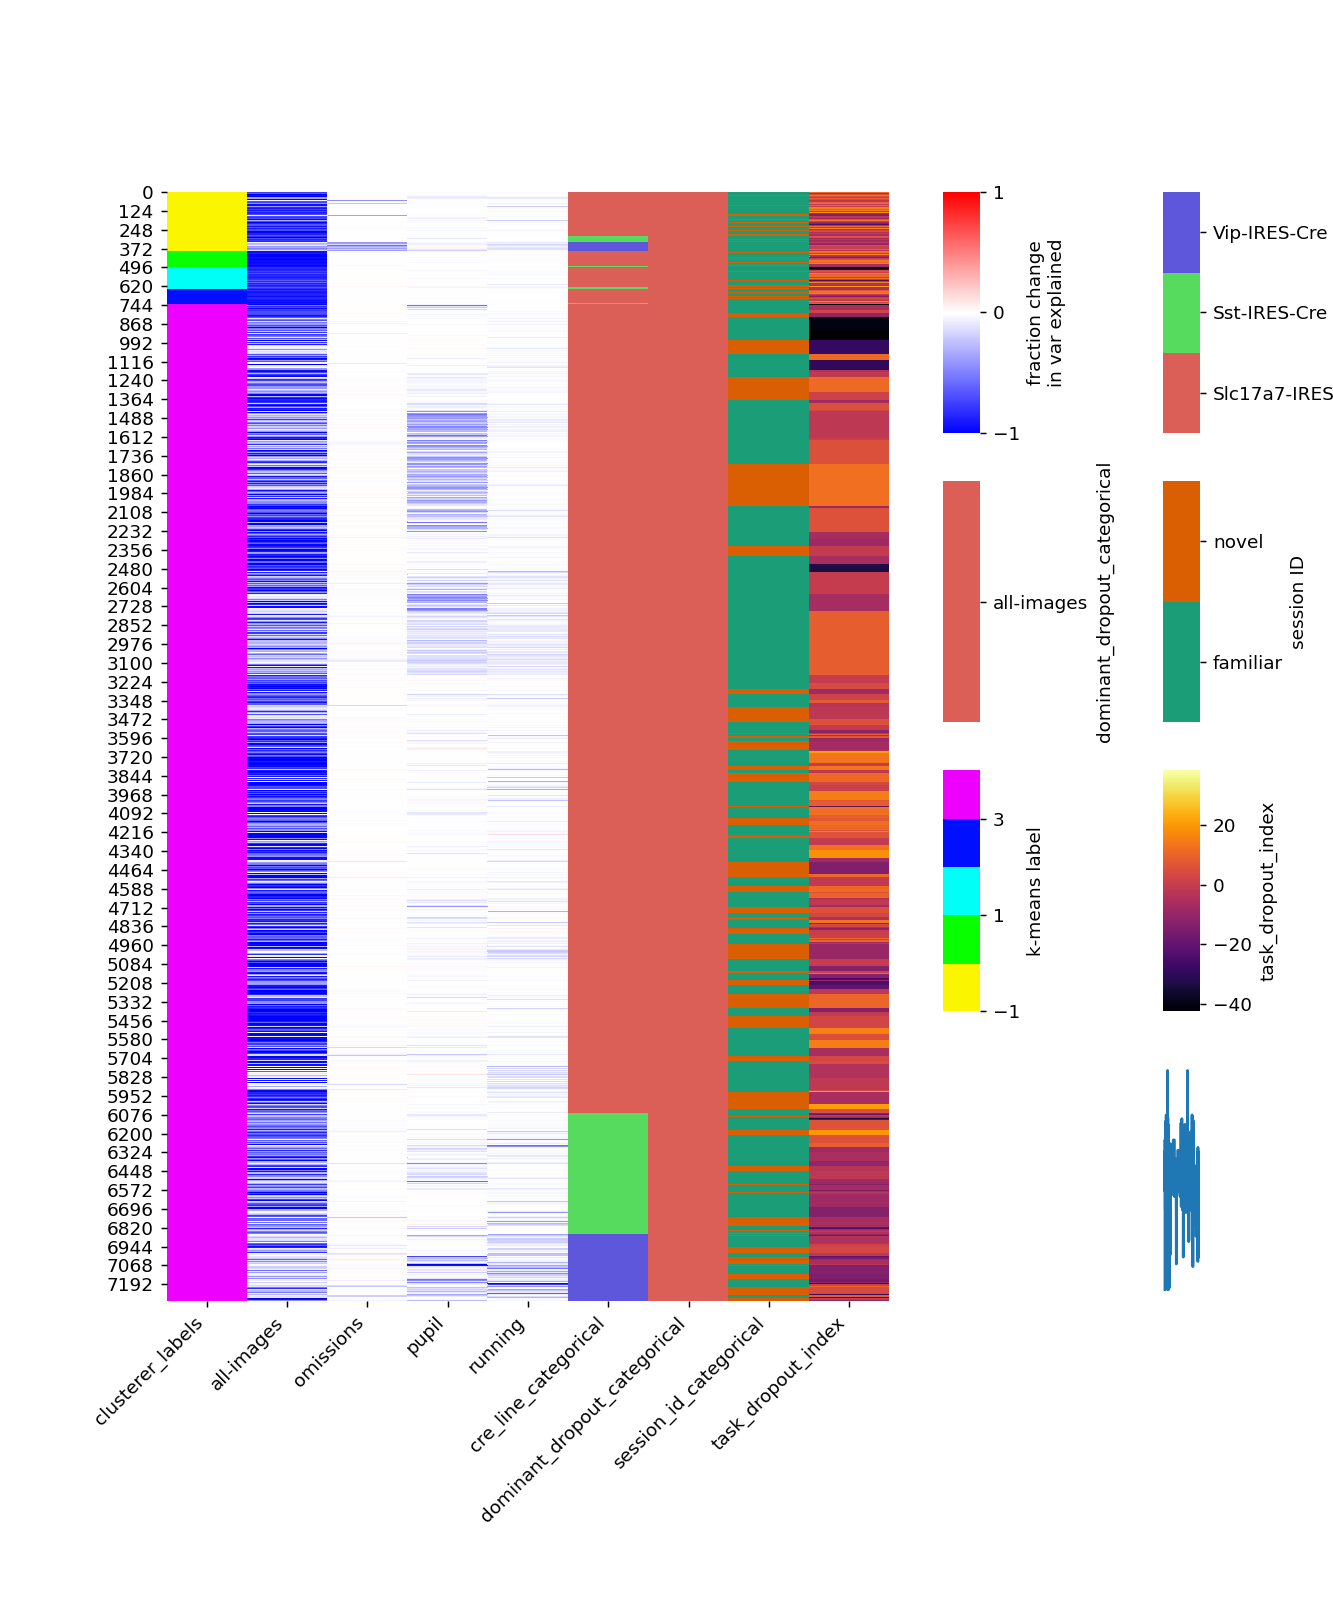

In [111]:
# sort_order = ['task_dropout_index', 'dominant_dropout','dominant_dropout_median','cre_line_categorical']
# sort_order = ['dominant_dropout','dominant_dropout_median','cre_line_categorical','session_id_categorical','imaging_depth',]
sort_order = ['clusterer_labels', 'dominant_dropout','dominant_dropout_median','cre_line_categorical']
# sort_order = ['clusterer_labels', 'task_dropout_index']
# sort_order = ['task_dropout_index']

sorted_data = gat.sort_data(rsp, sort_order, cluster_column_name='clusterer_labels')

fig, axes = vbp.make_multi_cmap_heatmap(
    sorted_data[cols_to_plot], 
    heatmap_defs, 
    figsize=(10,12), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.7, 
)

# for idx,row in sorted_data.query('cluster_transition').iterrows():
#     axes['heatmap'].axhline(idx,color='black')

## add pie charts for each cluster
Doc for pandas pie charts: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.pie.html

Note: It'd probably be better to normalize the values in the pie charts by their total number in in the dataset. For example, since there are far more Slc cells, they dominate every pie chart.

In [112]:
sorted_data['task_dropout_index'].values

array([-42.59250978, -40.09633643, -41.85736268, ...,  -4.2539034 ,
       -10.74115921, -10.74115921])

<IPython.core.display.Javascript object>


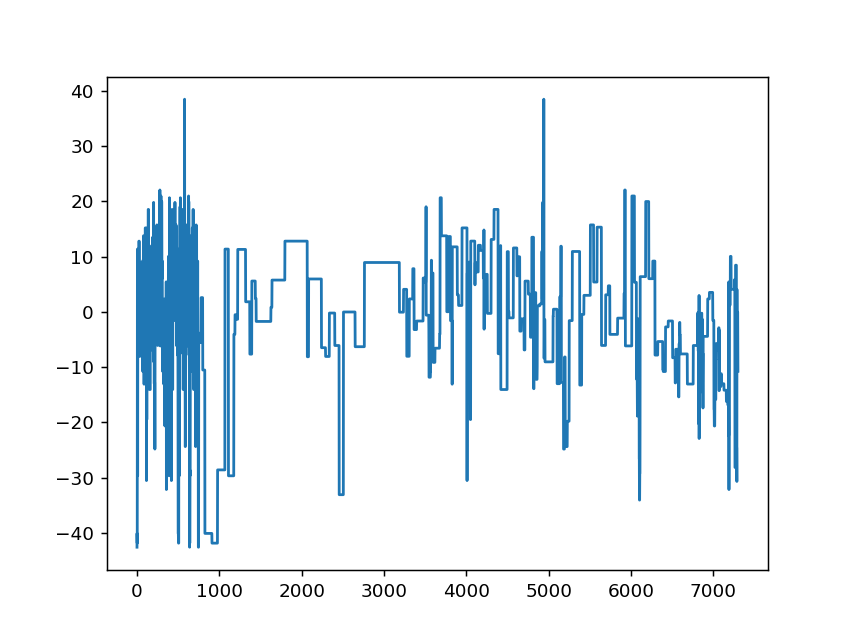

In [123]:
plt.figure(); plt.plot(topc)

In [148]:
row = 1
sd_this_bin = sorted_data[hist_inds == row]

parameters = ['all-images', 'omissions', 'pupil', 'running', 'imaging_depth']
col = 0
parameter = parameters[col]

nbins = 5
topc = sd_this_bin[parameter]
r = np.max(topc) - np.min(topc)
binEvery = r/float(nbins)
# set bins
bn = np.arange(np.min(topc), np.max(topc), binEvery)
# bn[-1] = np.max(topc)#+binEvery/10. # unlike digitize, histogram doesn't count the right most value

bn

array([-3.25749646, -2.5799499 , -1.90240334, -1.22485678, -0.54731022])

In [157]:
sd_this_bin.shape#[parameter].shape

(2616, 138)

In [159]:
for col,parameter in enumerate(parameters):
    print(col, parameter)

0 all-images
1 omissions
2 pupil
3 running
4 imaging_depth


In [152]:
sorted_data['task_dropout_index'].values.shape

(7300,)

In [165]:
sd_this_bin[parameters[0]].shape

(2616,)

In [167]:
plt.hist(
    sd_this_bin[parameters[0]],
    bins=bn,
    density=True)


(array([0.0044189 , 0.00773308, 0.06628353, 1.39747782]),
 array([-3.25749646, -2.5799499 , -1.90240334, -1.22485678, -0.54731022]),
 <a list of 4 Patch objects>)

In [175]:
sorted_data['imaging_depth_x'].iloc[0], sorted_data['imaging_depth_y'].iloc[0]

(375, 375.0)

<IPython.core.display.Javascript object>


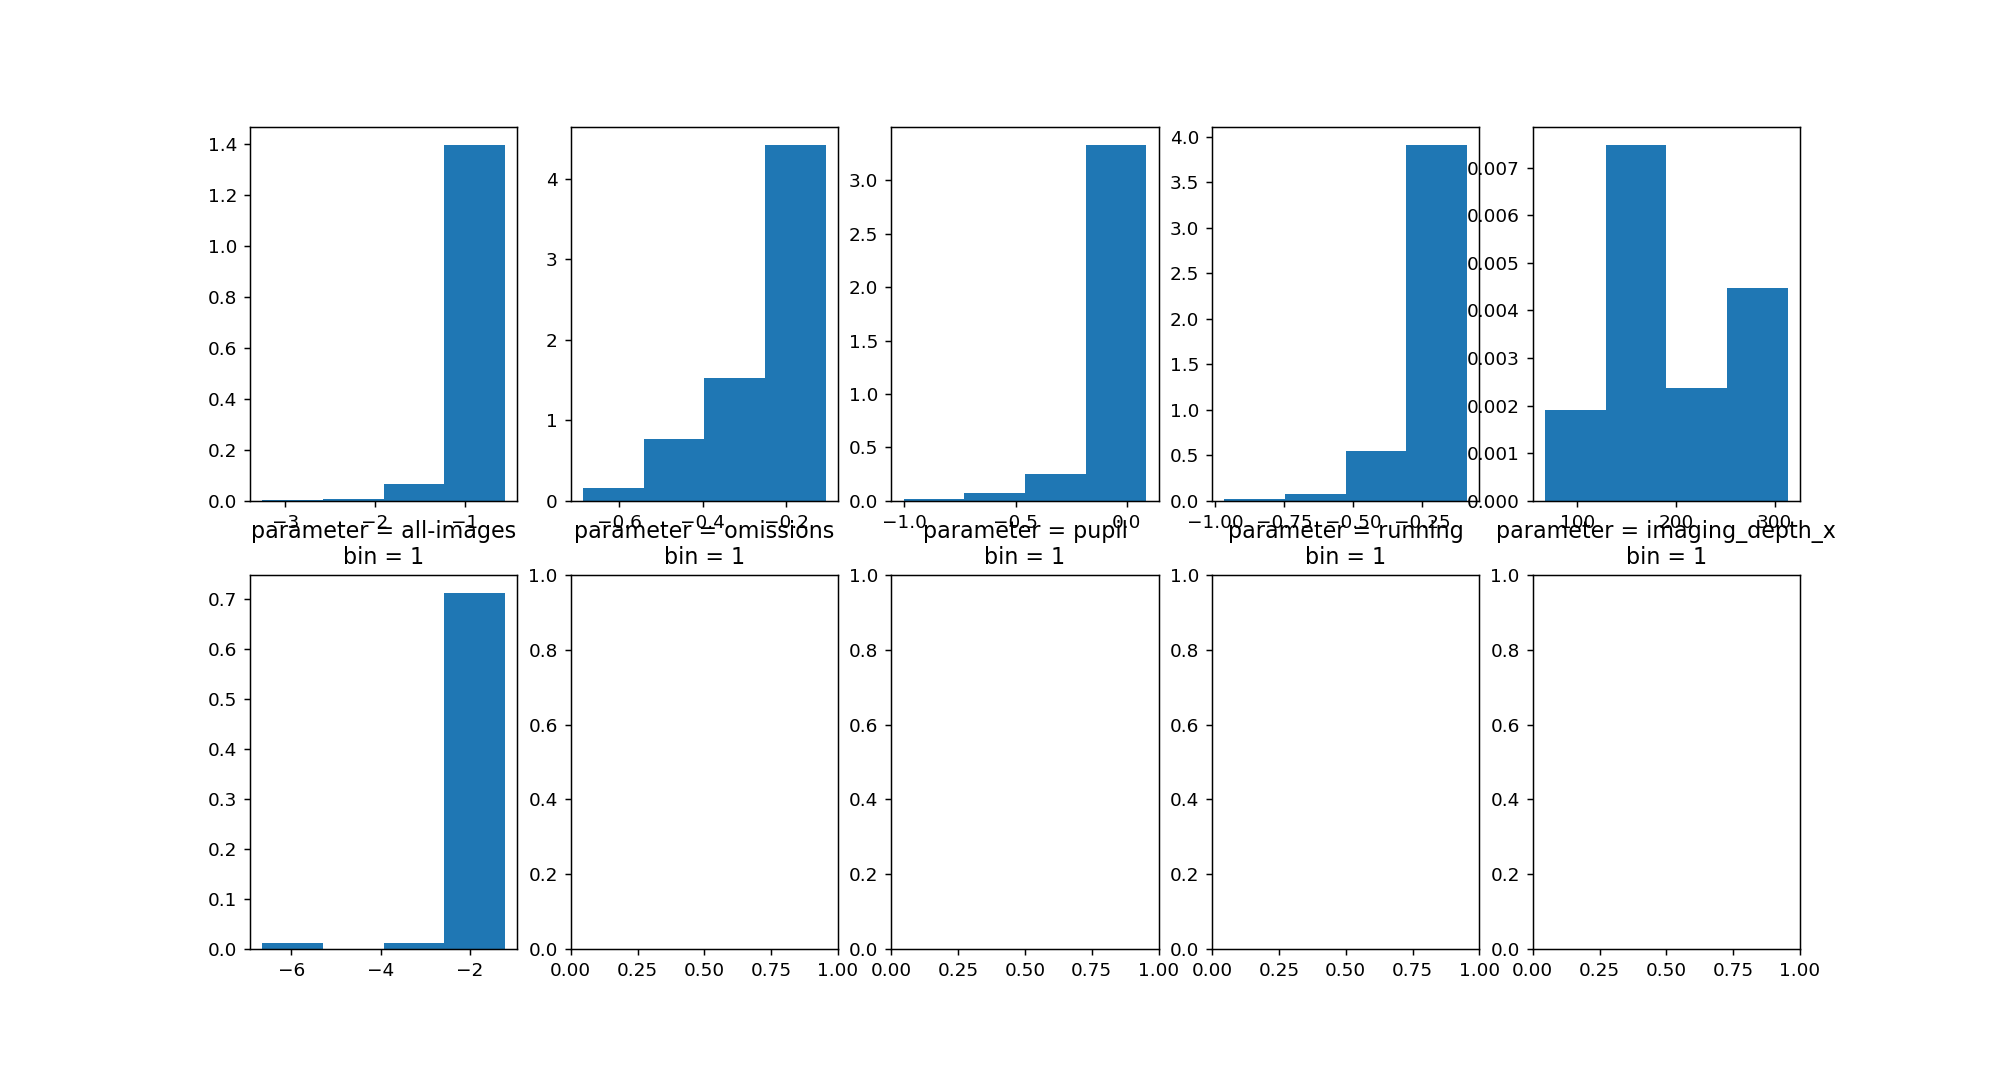

IndexError: index 2 is out of bounds for axis 0 with size 2

In [182]:
WORKING HERE:
    
#### continuous parameters    
# now for each bin, look at the distribution of a given parameter
parameters = ['all-images', 'omissions', 'pupil', 'running', 'imaging_depth_x']

fig,ax = plt.subplots(2, len(parameters),figsize=(15,8))

for row in np.unique(hist_inds):
    
    sd_this_bin = sorted_data[hist_inds == row]
    
    for col,parameter in enumerate(parameters):
        
#         print(parameter)
        
        nbins = 5
        topc = sd_this_bin[parameter]
        r = np.max(topc) - np.min(topc)
        binEvery = r/float(nbins)
        # set bins
        bn = np.arange(np.min(topc), np.max(topc), binEvery)
        
#         print(bn)
#         print(sd_this_bin.shape)

        ax[row-1,col].hist(
            sd_this_bin[parameter],
            bins=bn,
            density=True
        )

        # set titles, make first row title different
        if (row-1) == 0:
            ax[row, col].set_title('parameter = {}\nbin = {}'.format(parameter, row))
        else:
            ax[row, col].set_title('row = {}'.format(row))


In [136]:
topc = sorted_data['task_dropout_index'].values
nbins = 2

r = np.max(topc) - np.min(topc)
binEvery = r/float(nbins)
# set bins
bn = np.arange(np.min(topc), np.max(topc), binEvery)
# bn[-1] = np.max(topc)#+binEvery/10. # unlike digitize, histogram doesn't count the right most value
print(bn)

hist_inds = np.digitize(topc, bn)
hist_inds.shape
# np.unique(hist_inds)
sum(hist_inds==1), sum(hist_inds==2)

[-42.59250978  -2.05605504]


(2616, 4684)

In [113]:
# bin a feature, and then for each bin look at the distribution of a bunch of other features

topc = sorted_data['task_dropout_index'].values
nbins = 2

r = np.max(topc) - np.min(topc)
binEvery = r/float(nbins)
# set bins
bn = np.arange(np.min(topc), np.max(topc), binEvery)
bn[-1] = np.max(topc)#+binEvery/10. # unlike digitize, histogram doesn't count the right most value

hist_inds = np.digitize(topc, bn)

# hist, bin_edges = np.histogram(topc, bins=bn)
# hist = hist/float(np.sum(hist))    


#### continuous parameters    
# now for each bin, look at the distribution of a given parameter
parameters = ['all-images', 'omissions', 'pupil', 'running', 'imaging_depth_x']

fig,ax = plt.subplots(nbins, len(parameters),figsize=(15,35))

for row in np.unique(hist_inds):
    
    sd_this_bin = sorted_data[hist_inds == row]
    
    for col,parameter in enumerate(parameters):
        
        nbins = 5
        topc = sd_this_bin[parameter]
        r = np.max(topc) - np.min(topc)
        binEvery = r/float(nbins)
        # set bins
        bn = np.arange(np.min(topc), np.max(topc), binEvery)


        ax[row-1,col].hist(
            sd_this_bin[parameter],
            bins=bn,
            density=True
        )

        # set titles, make first row title different
        if row == 0:
            ax[row, col].set_title('parameter = {}\nbin = {}'.format(parameter, row))
        else:
            ax[row, col].set_title('row = {}'.format(row))


#### categorical parameters    
# now for each bin, look at the pie chart of a given parameter
parameters = [['cre_line','session_id','targeted_structure', 'clusterer_labels']]

for row in range(len(hist_inds)):
    sd_this_bin = sorted_data[hist_inds == row]
    
    for col,parameter in enumerate(parameters):
        
        # build a dataframe of value counts for the pie chart (there's probably a better way!)
        DOUBLE check below
        df = pd.DataFrame(sd_this_bin[parameter].value_counts()).sort_index()
        plot = df.plot.pie(
            y = parameter, 
            ax = ax[row,col],
            legend = False
        )
        ax[row,col].set_ylabel('')

        # set titles, make first row title different
        if row == 0:
            ax[row, col].set_title('parameter = {}\nbin = {}'.format(parameter, row))
        else:
            ax[row, col].set_title('row = {}'.format(row))
            

SyntaxError: invalid syntax (<ipython-input-113-272ada26ee1b>, line 50)

In [ ]:
# For each cluster id, we compute a given parameter's distribution; e.g. for cluster_id 0, we compute the number of cells that took each value of "session_id"

fig,ax = plt.subplots(20,4,figsize=(15,35))

parameters = ['cre_line','session_id','targeted_structure', 'imaging_depth']

for row,cluster_id in enumerate(sorted_data['clusterer_labels'].unique()):
    for col,parameter in enumerate(parameters):
        # make a histogram of imaging depths
        if parameter == 'imaging_depth':
            ax[row,col].hist(
                sorted_data.query('clusterer_labels == @cluster_id')['imaging_depth'],
                bins=np.arange(0,400,50),
                density=True
            )
            
        # make a pie chart for the rest
        else:
            # build a dataframe of value counts for the pie chart (there's probably a better way!)
            df = pd.DataFrame(sorted_data.query('clusterer_labels == @cluster_id')[parameter].value_counts()).sort_index()
            plot = df.plot.pie(
                y = parameter, 
                ax = ax[row,col],
                legend = False
            )
            ax[row,col].set_ylabel('')
        
        # set titles, make first row title different
        if row == 0:
            ax[row, col].set_title('parameter = {}\ncluster ID = {}'.format(parameter, cluster_id))
        else:
            ax[row, col].set_title('cluster ID = {}'.format(cluster_id))
            
            
fig.tight_layout()

## another sorting, with imaging_depth being the emphasis

In [ ]:
sort_order = ['dominant_dropout','dominant_dropout_median','imaging_depth','cre_line_categorical','session_id_categorical']
sorted_data = gat.sort_data(rsp, sort_order, cluster_column_name='clusterer_labels')

fig, axes = vbp.make_multi_cmap_heatmap(
    sorted_data[cols_to_plot], 
    heatmap_defs, 
    figsize=(10,12), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.7, 
)
for idx,row in sorted_data.query('cluster_transition').iterrows():
    axes['heatmap'].axhline(idx,color='black')

## and another sorting, with session_id being the emphasis

In [ ]:
sort_order = ['dominant_dropout','dominant_dropout_median','session_id_categorical','cre_line_categorical','imaging_depth',]
sorted_data = gat.sort_data(rsp, sort_order, cluster_column_name='clusterer_labels')

fig, axes = vbp.make_multi_cmap_heatmap(
    sorted_data[cols_to_plot], 
    heatmap_defs, 
    figsize=(10,10), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.7, 
)
for idx,row in sorted_data.query('cluster_transition').iterrows():
    axes['heatmap'].axhline(idx,color='black')

## sort by structure after dropout

In [ ]:
sort_order = ['dominant_dropout','dominant_dropout_median','targeted_structure_categorical','cre_line_categorical','session_id_categorical','imaging_depth']
sorted_data = gat.sort_data(rsp, sort_order, cluster_column_name='clusterer_labels')

fig, axes = vbp.make_multi_cmap_heatmap(
    sorted_data[cols_to_plot], 
    heatmap_defs, 
    figsize=(10,15), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.7, 
)
for idx,row in sorted_data.query('cluster_transition').iterrows():
    axes['heatmap'].axhline(idx,color='black')

## Sort by cluster ID and move it to the leftmost column

In [ ]:
sort_order = ['clusterer_labels','cre_line_categorical','session_id_categorical','imaging_depth']
sorted_data = gat.sort_data(rsp, sort_order, cluster_column_name='clusterer_labels')

cols_to_plot = [
    'clusterer_labels', 
    'all-images', 
    'omissions', 
    'pupil', 
    'running',
    'cre_line_categorical', 
    'session_id_categorical', 
    'equipment_name_categorical',
    'targeted_structure_categorical',
    'imaging_depth'
]

fig, axes = vbp.make_multi_cmap_heatmap(
    sorted_data[cols_to_plot], 
    heatmap_defs, 
    figsize=(10,10), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.7, 
)
for idx,row in sorted_data.query('cluster_transition').iterrows():
    axes['heatmap'].axhline(idx,color='black')